**1. Noise Removal and Reconstruction:**

The code applies various filters to clean the images from noise and reconstruct the shapes. These filters include **Mean Filter, Median Blur, Gaussian Blur, Bilateral Filter, Non-local Means, and Unsharp Filter**.



From the results, it is observed that the **Non-Local Means** filter performs the best among all other filters in cleaning the noise in the pictures. This filter is particularly effective in preserving edges and details while reducing noise, making it a suitable choice for noise removal in images.

On the other hand, the worst-performing filter is the **Median Filter**, which, in most cases, removes almost everything from the pictures. This is not effective in keeping the main content of the images intact.




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


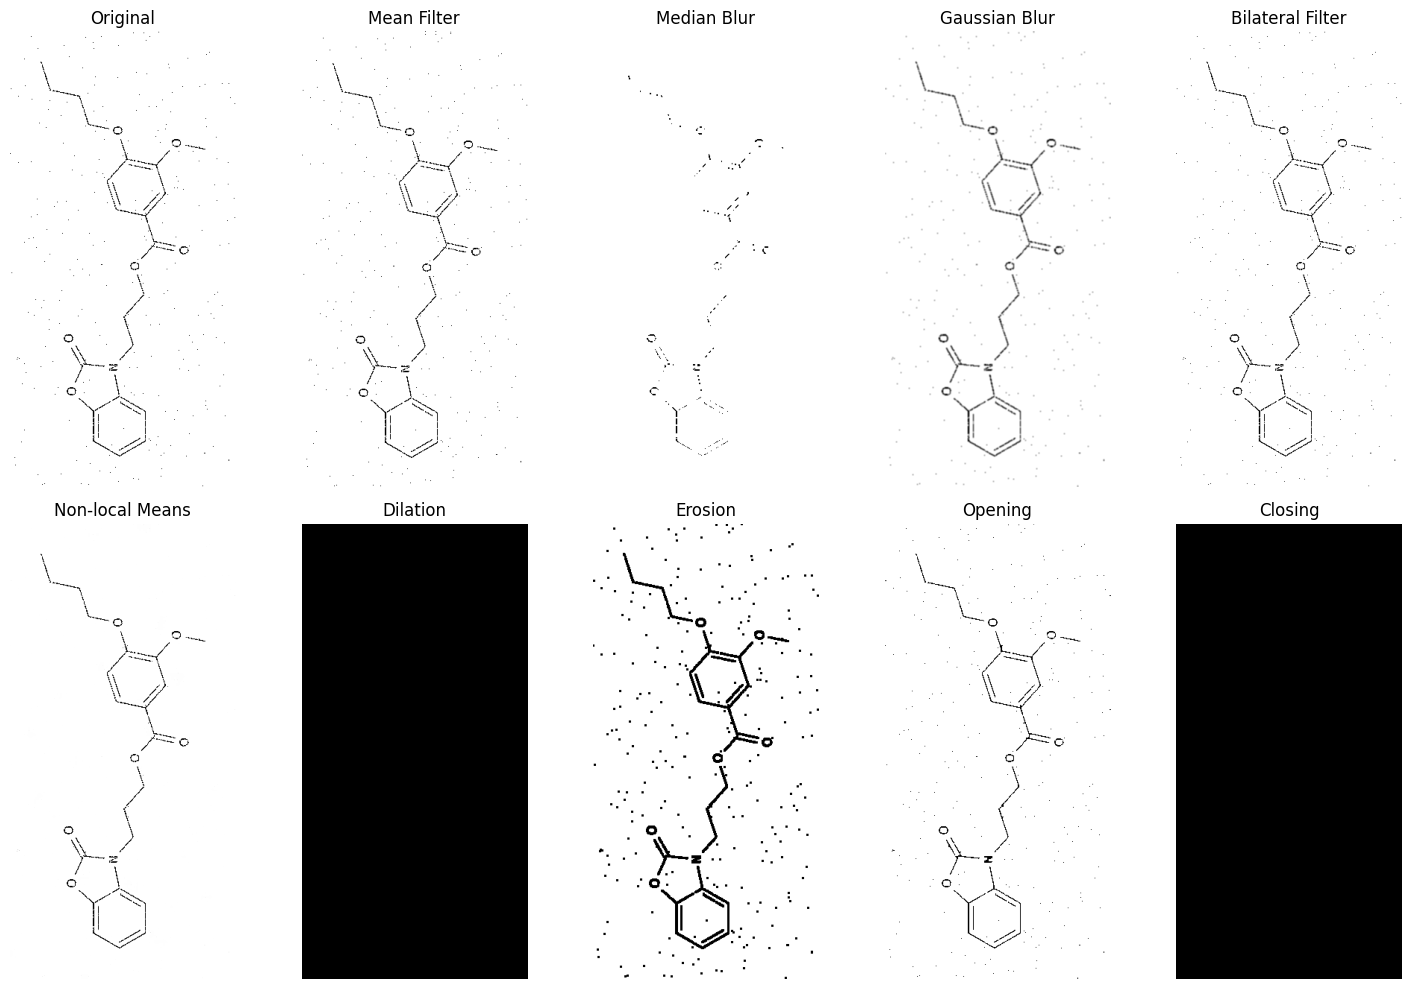

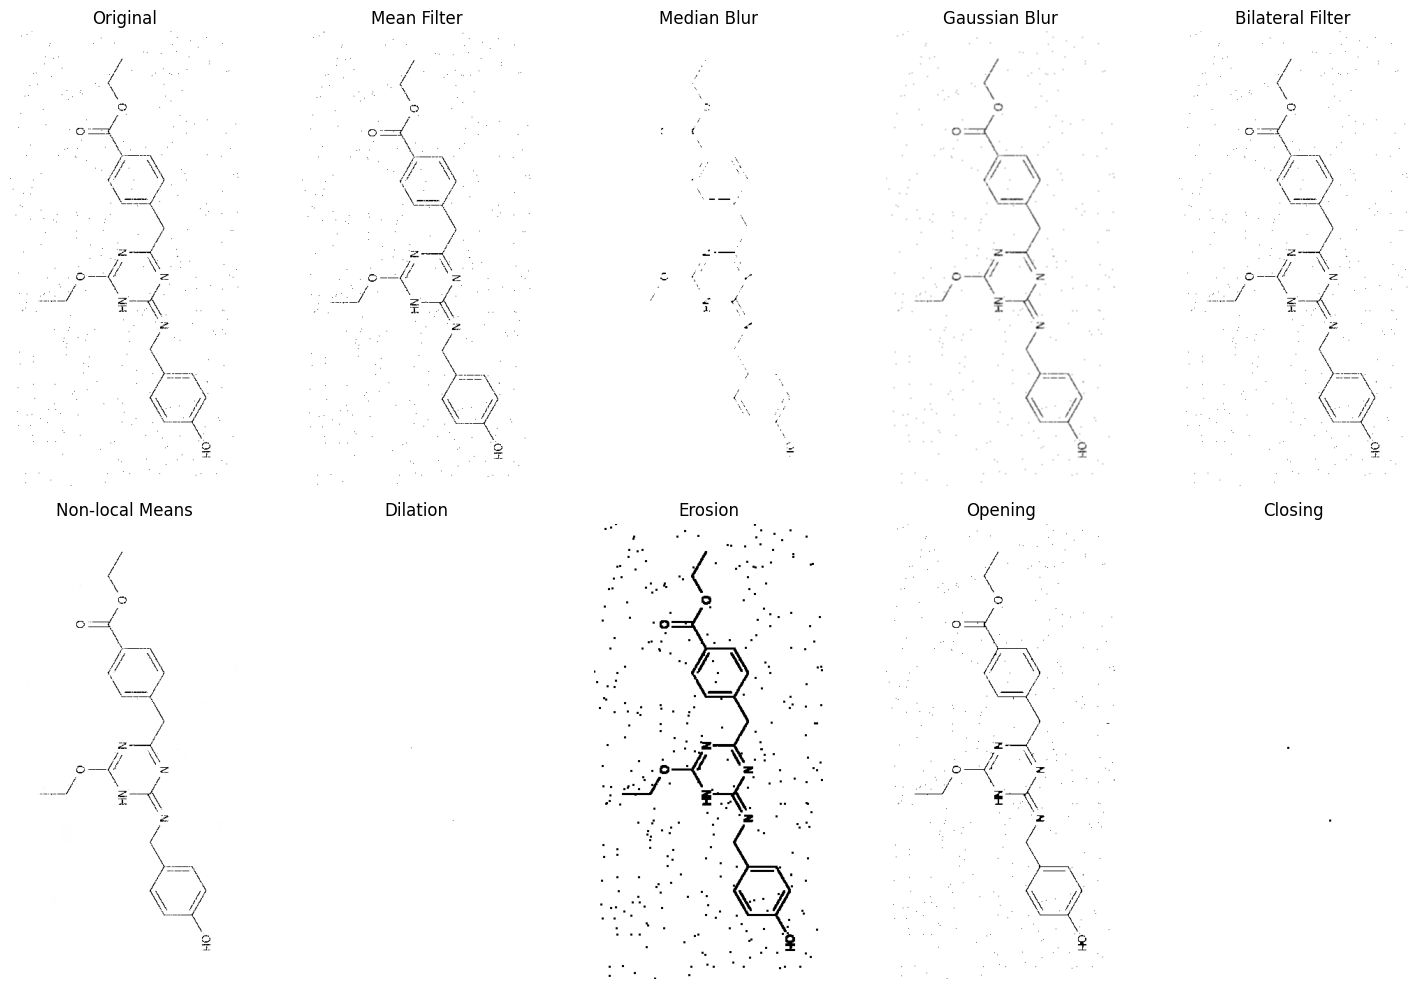

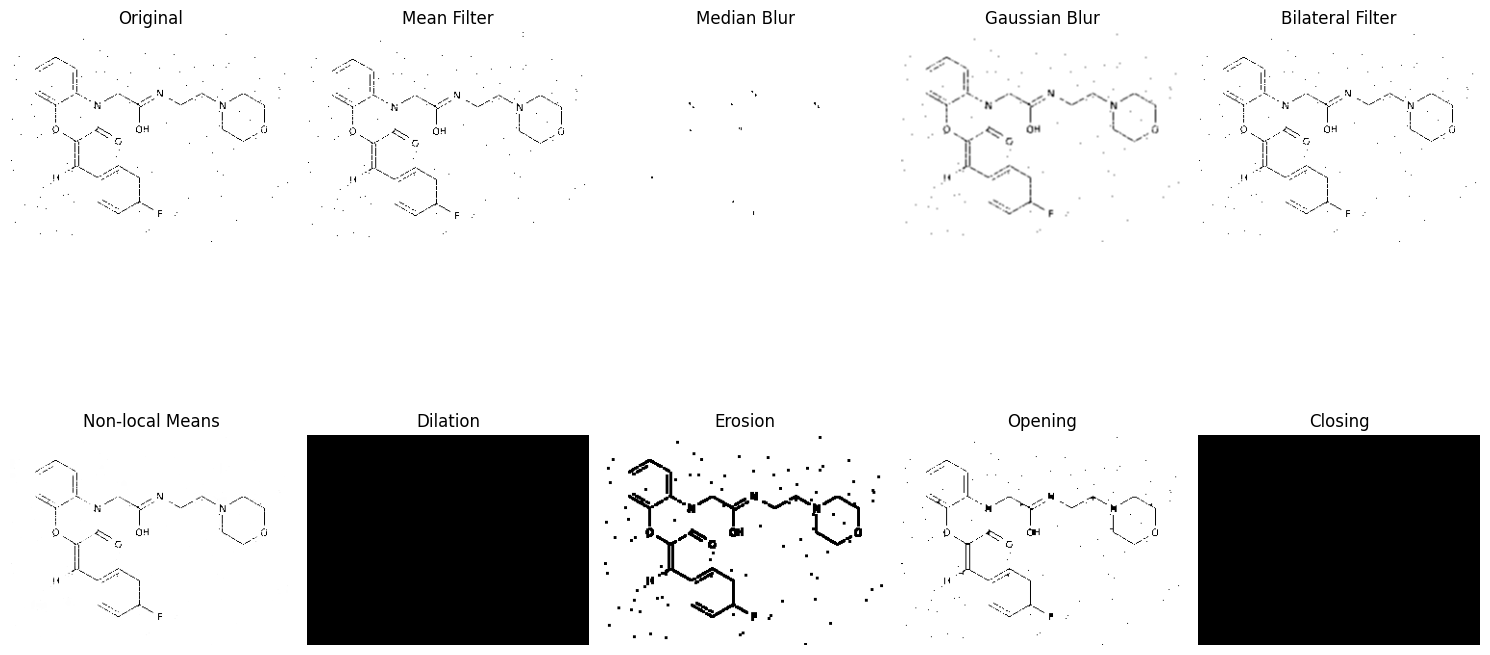

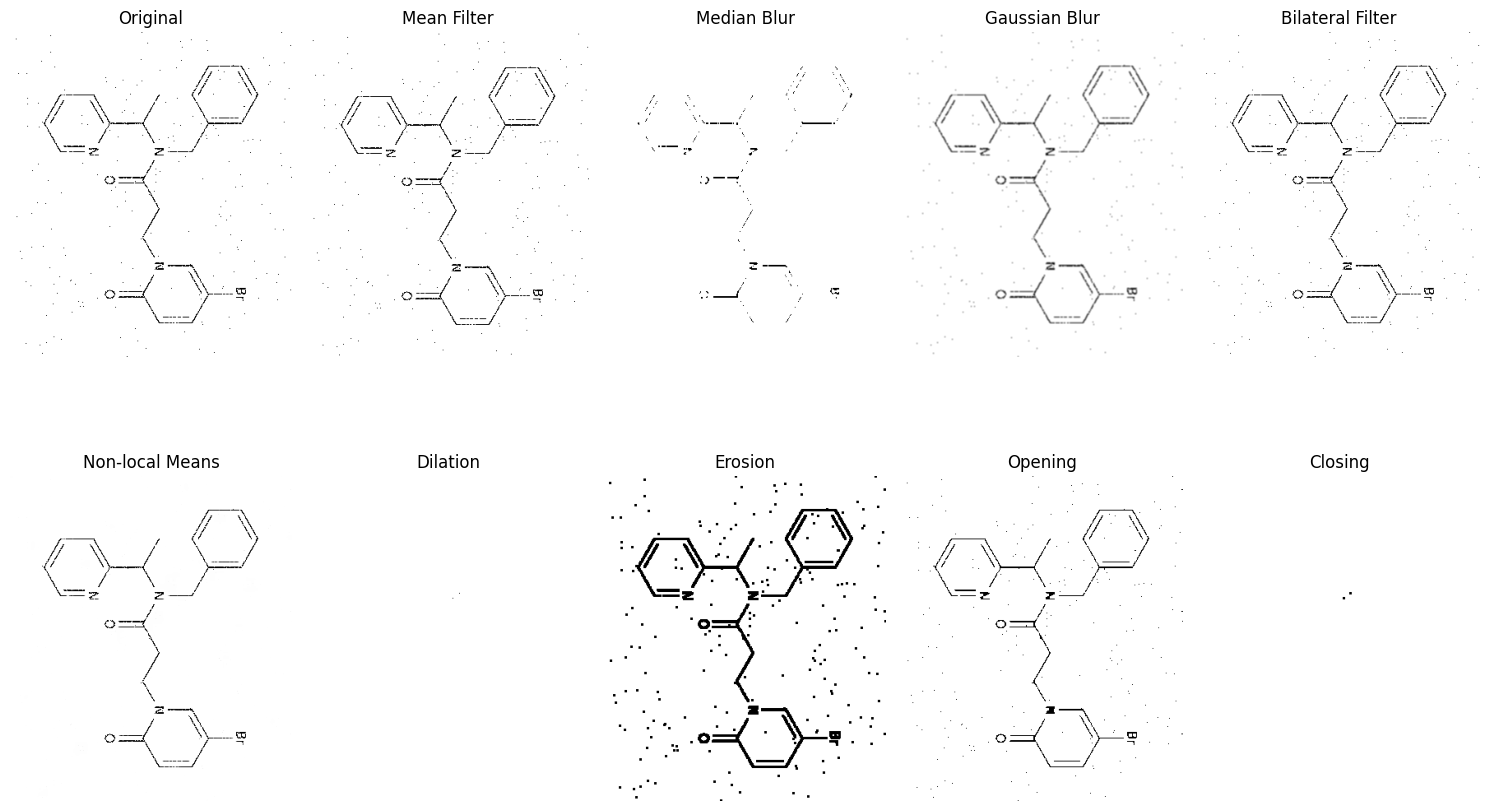

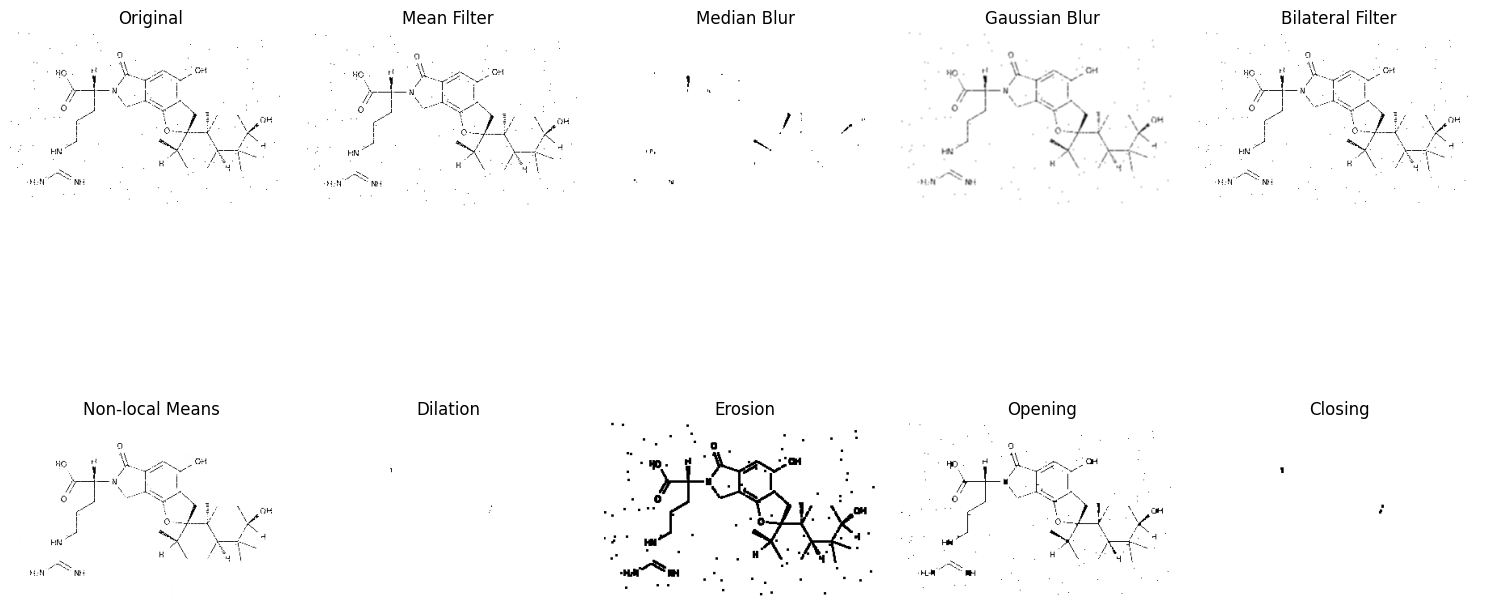

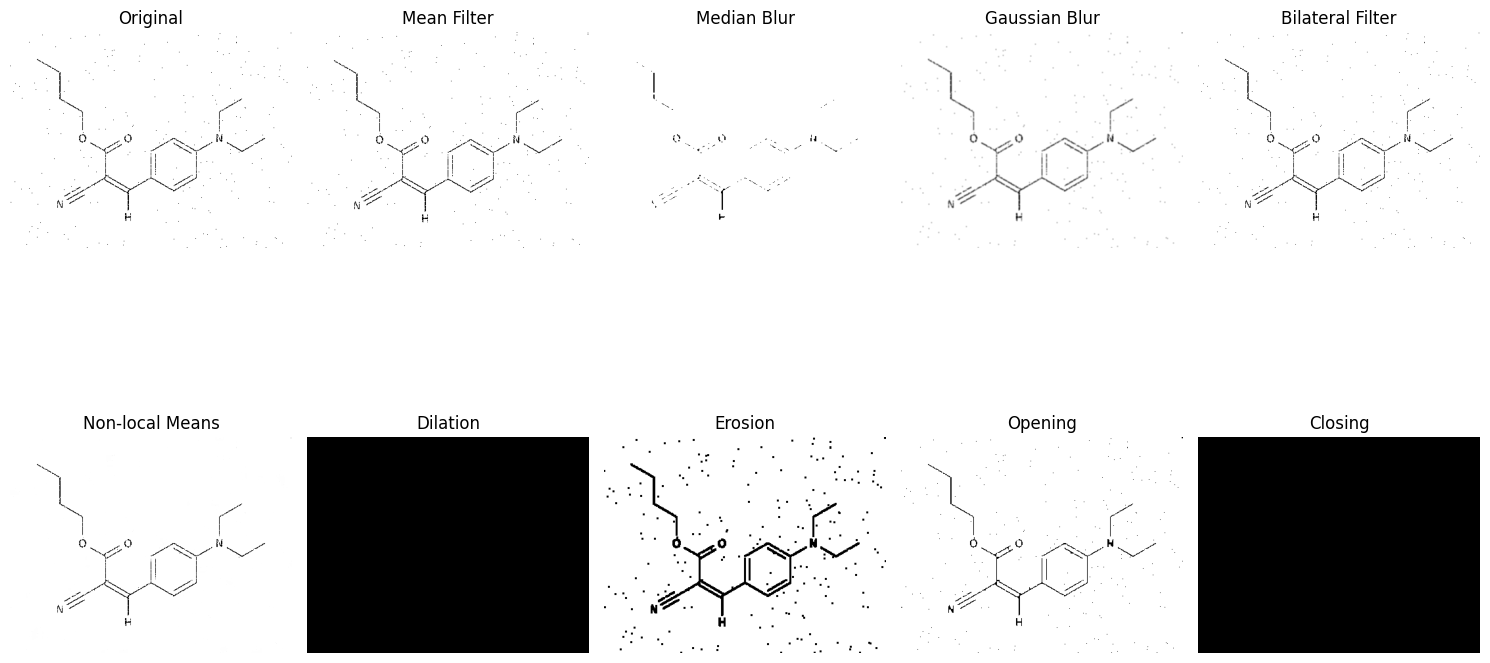

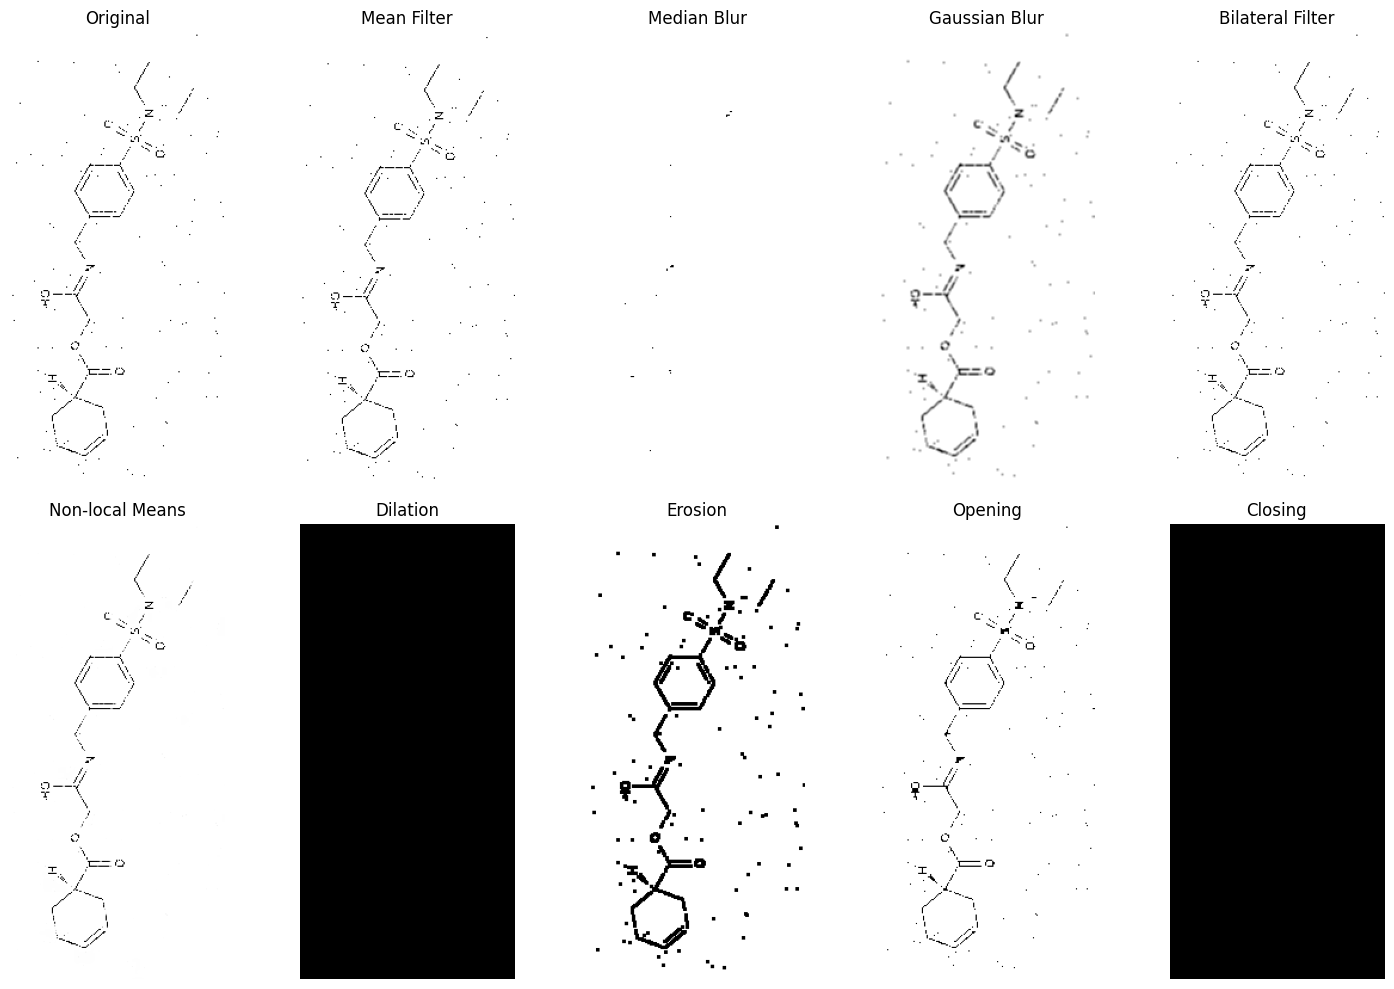

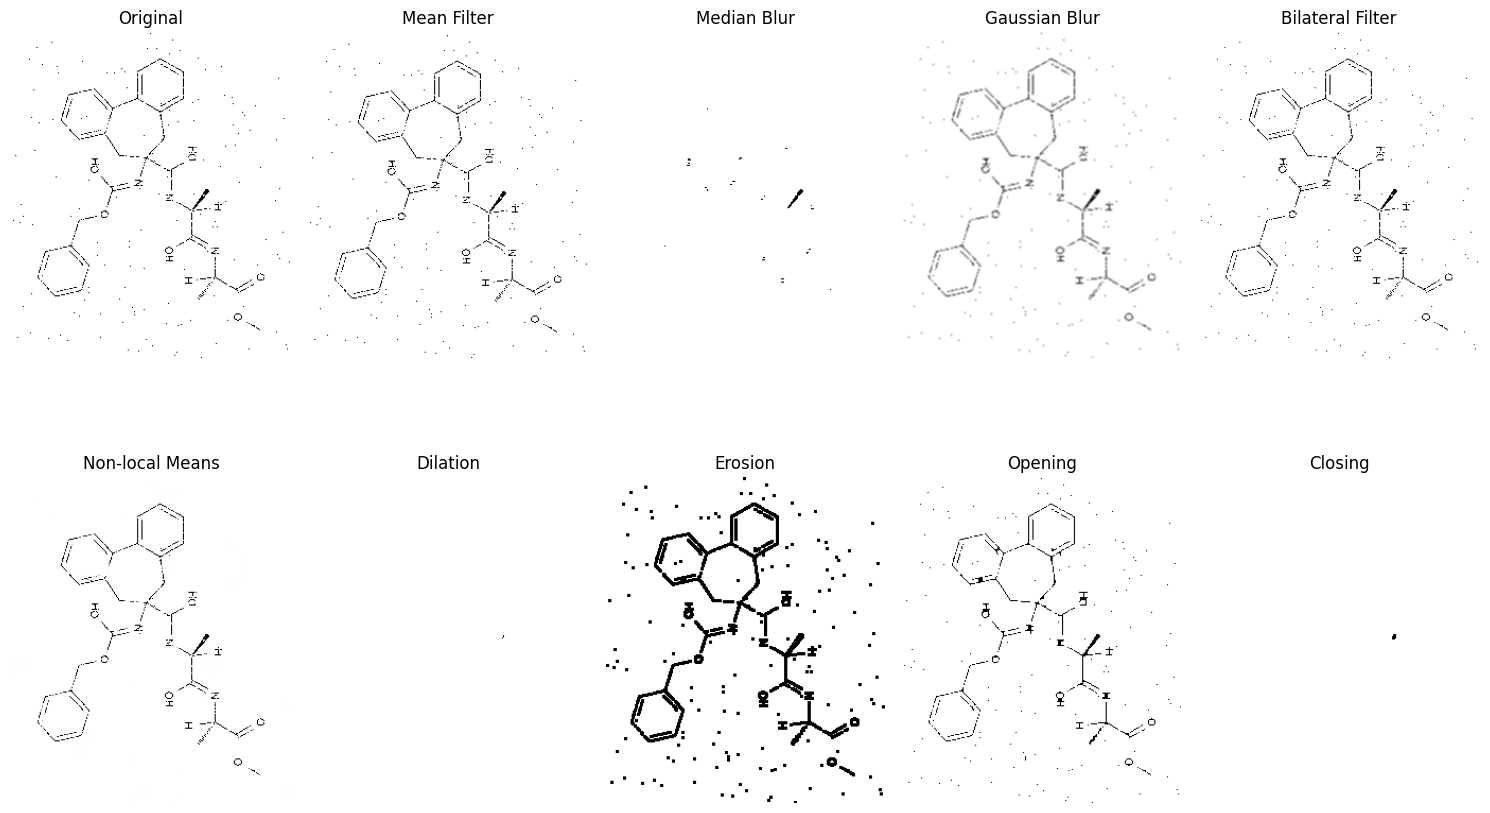

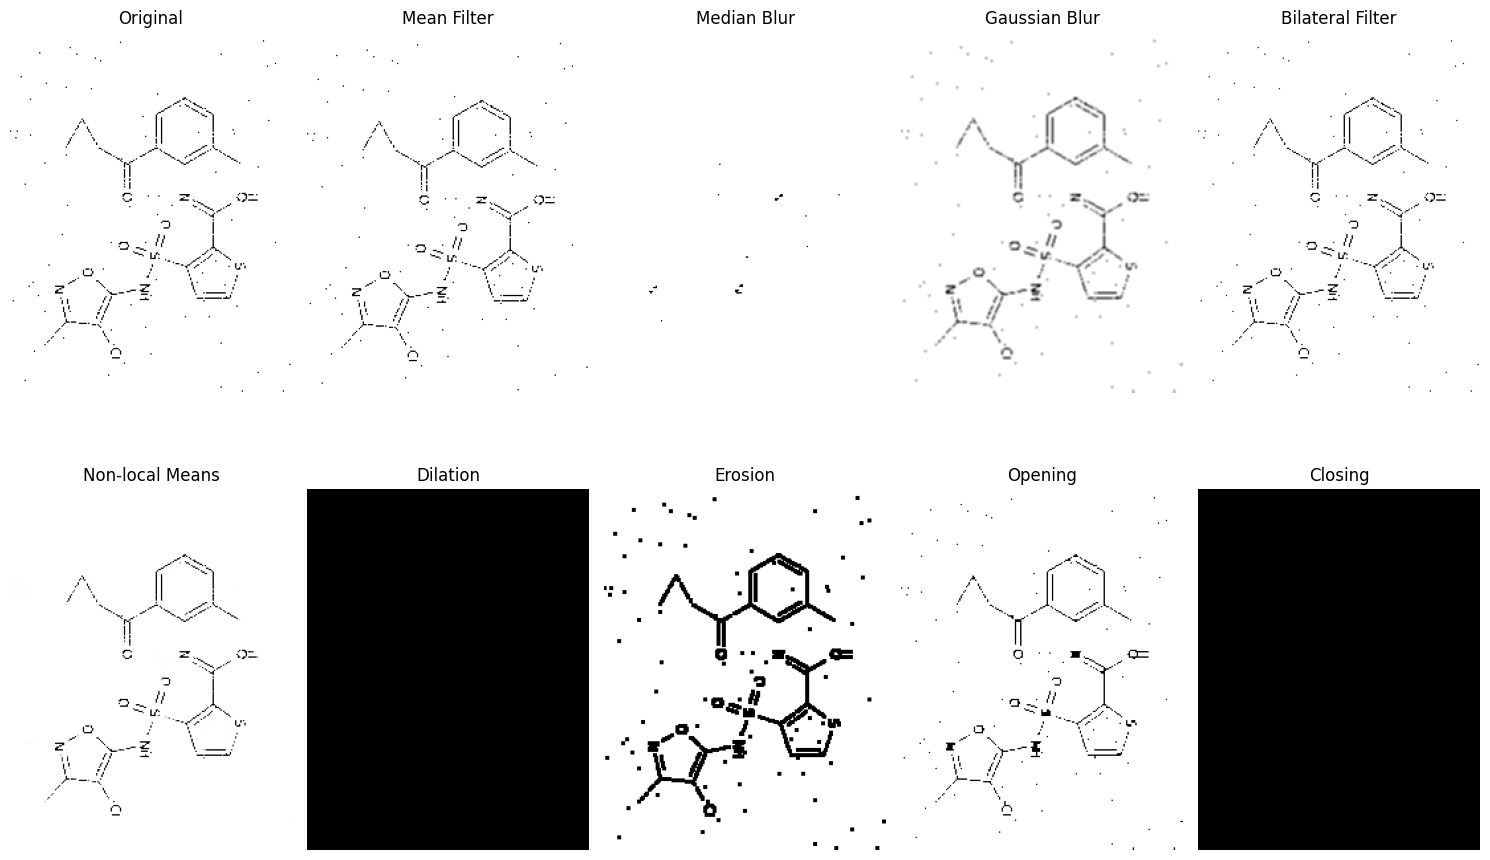

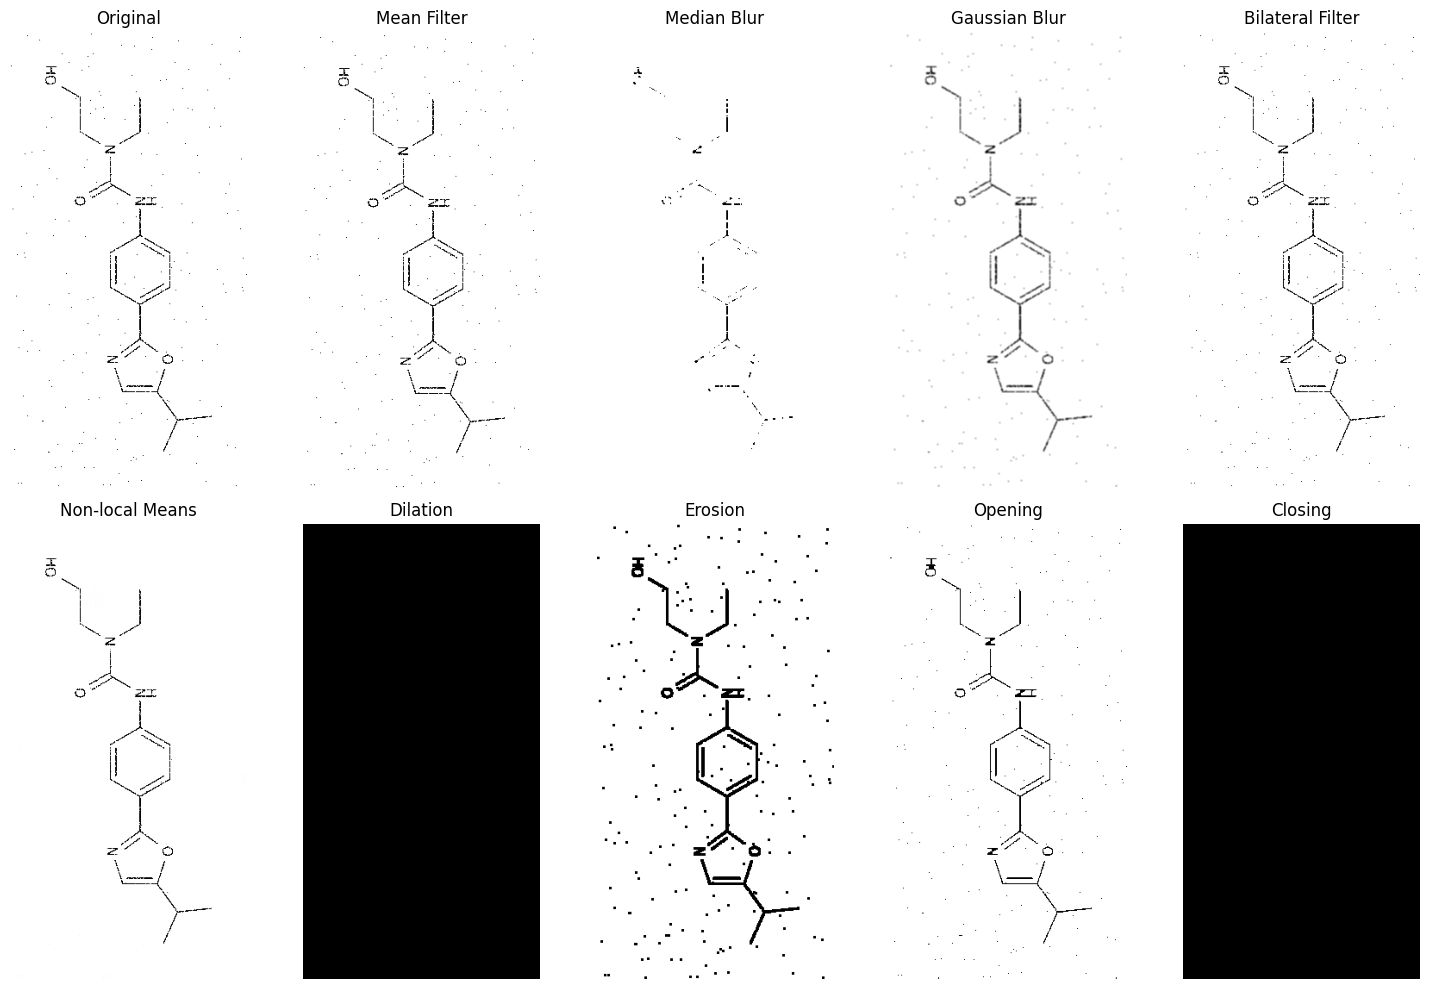

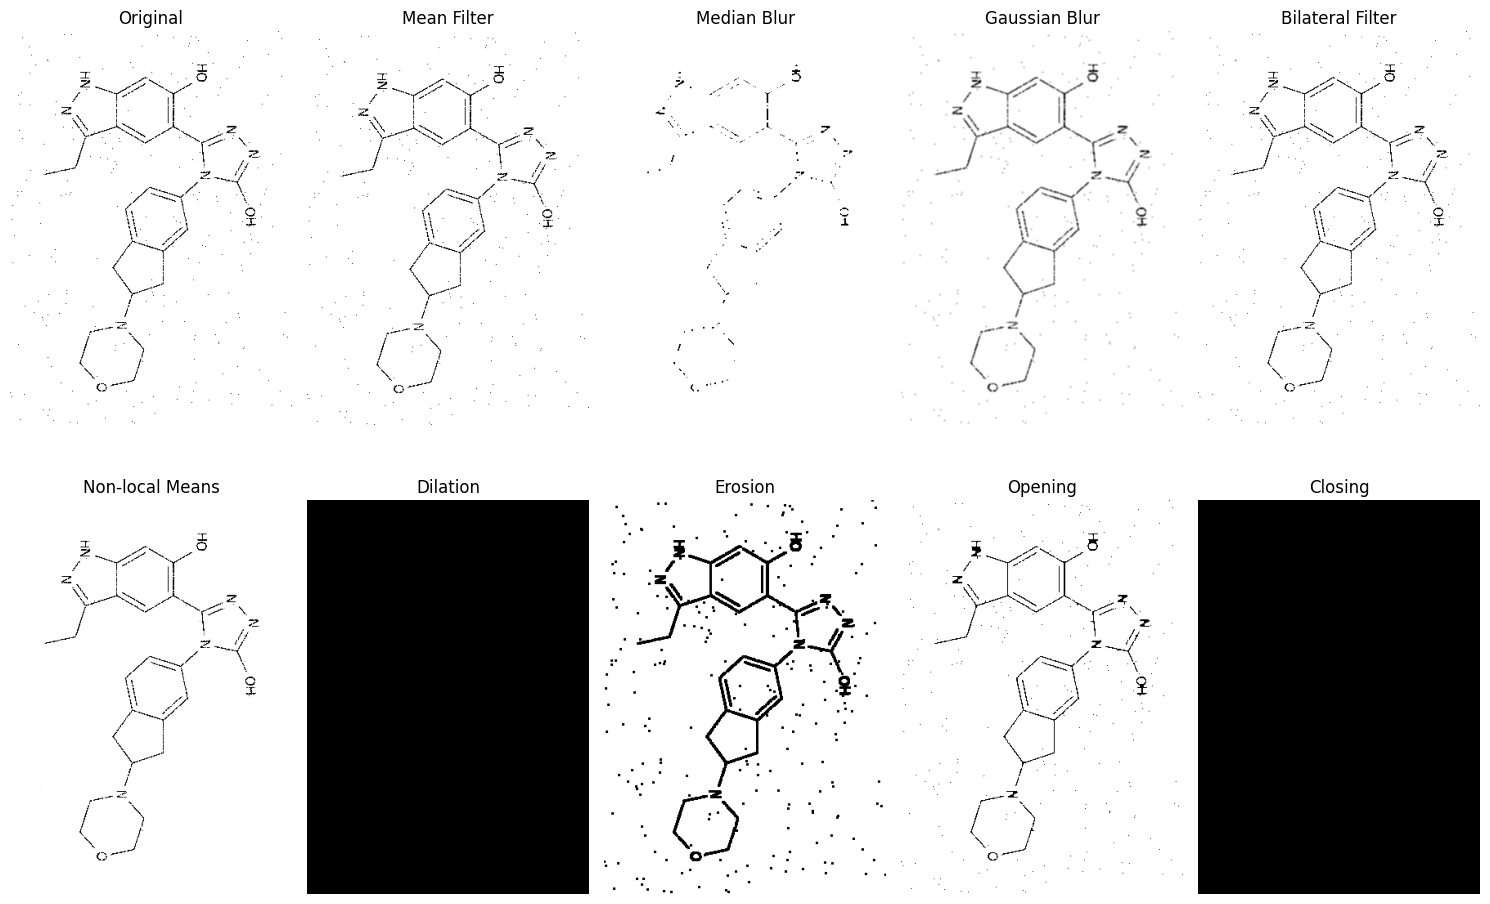

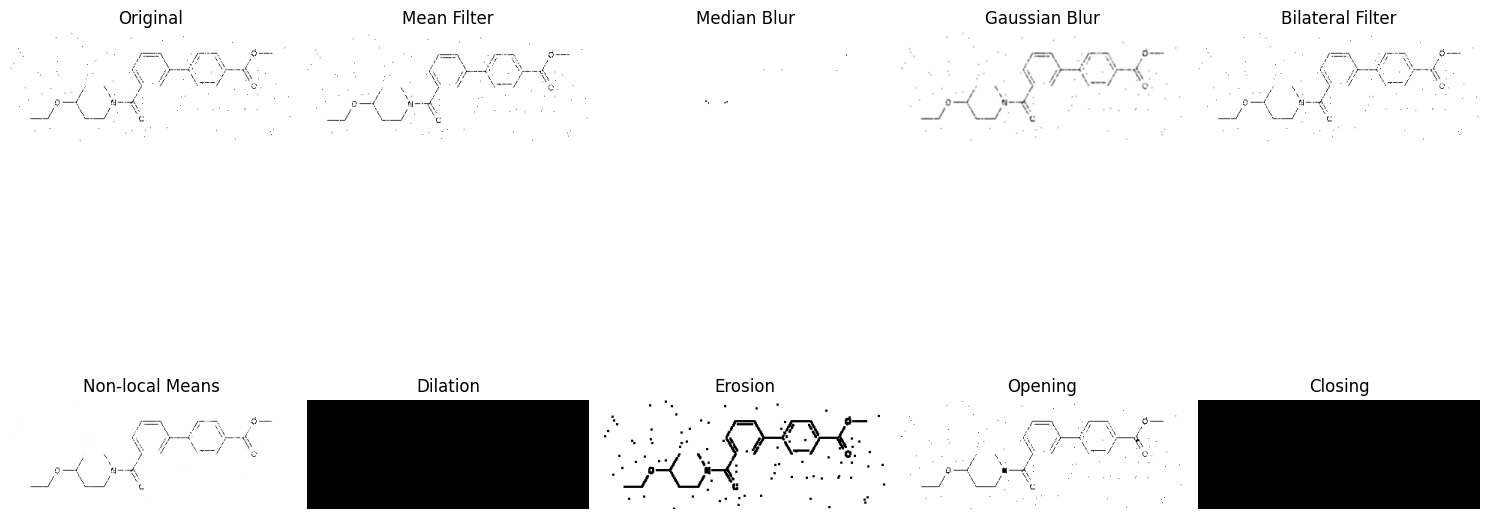

In [30]:
from google.colab import drive
from skimage.metrics import structural_similarity as ssim
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Mount Google Drive
drive.mount('/content/drive')

def load_image(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Could not load image at path: {path}")
    return image


def apply_filters(image):
    kernel_size = 3  # Kernel size for mean, median, and Gaussian blur
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

    filters = {
        'Mean Filter': cv2.filter2D(image, -1, kernel_size),
        'Median Blur': cv2.medianBlur(image, kernel_size),
        'Gaussian Blur': cv2.GaussianBlur(image, (kernel_size, kernel_size), 0),
        'Bilateral Filter': cv2.bilateralFilter(image, 9, 75, 75),
        'Non-local Means': cv2.fastNlMeansDenoising(image, None, 30, 7, 21),
        'Dilation': cv2.dilate(image, kernel, iterations=1),
        'Erosion': cv2.erode(image, kernel, iterations=1),
        'Opening': cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel),
        'Closing': cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    }

    return filters




def show_images_and_save_outputs(original, filtered_images, original_path, output_dir):
    # Create subplots for each filter operation
    fig, axes = plt.subplots(2, (len(filtered_images) + 1) // 2, figsize=(15, 10))
    axes = axes.ravel()

    # Display the original image
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')

    # Display each filtered image
    for i, (filter_name, image) in enumerate(filtered_images.items(), start=1):
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(filter_name)
        axes[i].axis('off')

        # Save each filtered image
        basename = os.path.splitext(os.path.basename(original_path))[0]
        output_filename = f"{basename}_{filter_name.replace(' ', '_')}_output.png"
        output_path = os.path.join(output_dir, output_filename)
        cv2.imwrite(output_path, image)

    plt.tight_layout()
    plt.show()



def process_images(image_paths, output_dir):
    results = {}
    for path in image_paths:
        original = load_image(path)
        filtered_images = apply_filters(original)
        ssim_scores = analyze_effect(original, filtered_images)
        show_images_and_save_outputs(original, filtered_images, path, output_dir)
        results[path] = ssim_scores
    return results

def main():
    # Input and output directories on Google Drive
    base_input_dir = '/content/drive/My Drive/a3-digital-image-processing-tmehtiyev2019/input_pictures/noisy/chemical/'
    base_output_dir = '/content/drive/My Drive/a3-digital-image-processing-tmehtiyev2019/output_pictures/noisy/chemical/'
    os.makedirs(base_output_dir, exist_ok=True)

    # Retrieve image paths
    image_paths = [os.path.join(base_input_dir, f) for f in os.listdir(base_input_dir) if f.endswith('.png')]

    # Process and save results
    results = process_images(image_paths, base_output_dir)


if __name__ == '__main__':
    main()


**2.Speckle Removal:**

The code applies various filters to remove speckle noise from the images. These filters include **Gaussian Blur, Median Blur, Bilateral Filter, Non-local Means, and Crimmins Speckle Removal**.

Among these filters, the Crimmins Speckle Removal technique is specifically designed for speckle noise reduction. It works by adjusting the pixel values based on the intensity of their neighboring pixels, effectively reducing speckle noise while preserving image details.

From the results, it can be observed that the **Non-Local Means filter** also performs the best for speckle noise, similar to its performance in noise removal for the chemical images. This filter is effective in preserving edges and details while reducing noise, making it a suitable choice for speckle noise removal.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


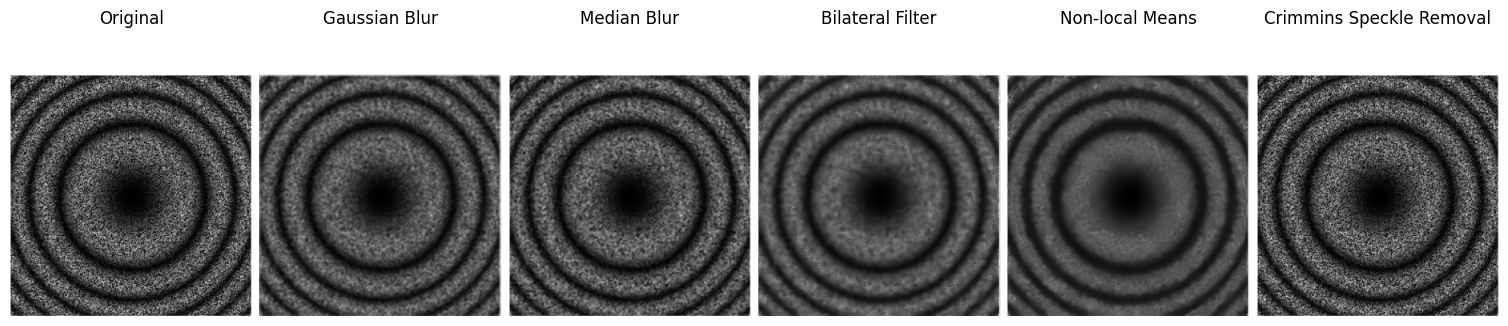

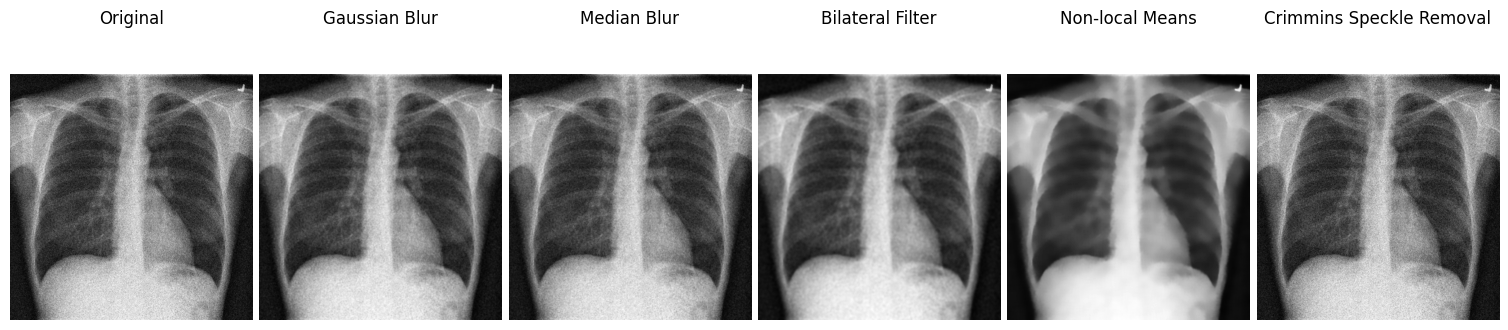

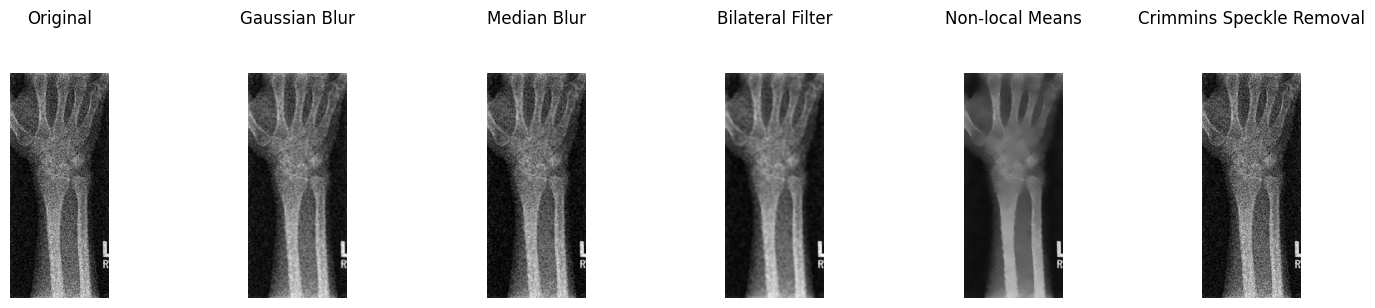

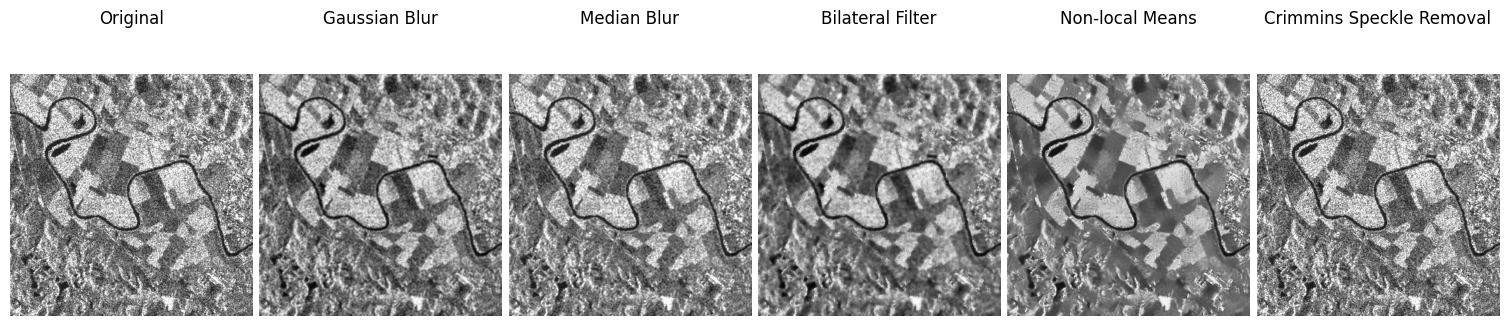

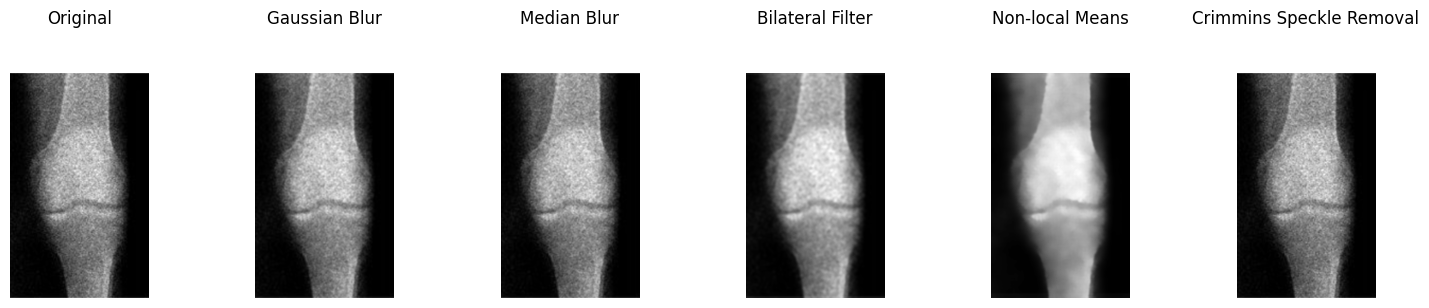

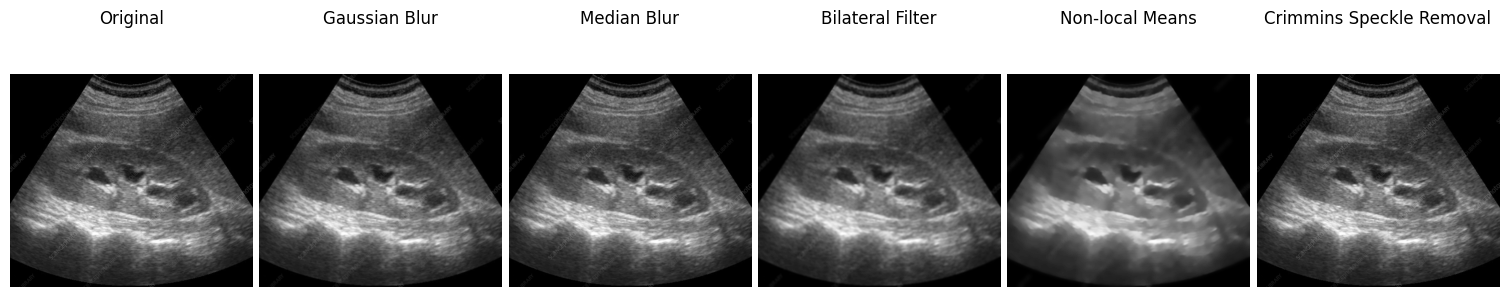

In [22]:
from google.colab import drive
from skimage.metrics import structural_similarity as ssim
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Mount Google Drive
drive.mount('/content/drive')

def load_image(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Could not load image at path: {path}")
    return image

def adjust_pixels(image, operation):
    # Extend the image borders to handle edge pixels
    padded_image = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_REPLICATE)
    adjusted_image = np.zeros_like(image)

    for y in range(1, padded_image.shape[0] - 1):
        for x in range(1, padded_image.shape[1] - 1):
            # Extract the 3x3 neighbourhood
            neighbourhood = padded_image[y-1:y+2, x-1:x+2]
            # Apply the operation to the neighbourhood and central pixel
            adjusted_image[y-1, x-1] = operation(neighbourhood, padded_image[y, x])

    return adjusted_image

def crimmins(data):
    # Dark pixel adjustment
    def dark_adjustment(neighbours, self):
        return self + 1 if (neighbours >= self + 2).sum() >= 3 else self

    # Light pixel adjustment
    def light_adjustment(neighbours, self):
        return self - 1 if (neighbours <= self - 2).sum() >= 3 else self

    data = data.astype(np.float32)
    dark_adjusted = adjust_pixels(data, dark_adjustment)
    light_adjusted = adjust_pixels(dark_adjusted, light_adjustment)

    # Convert the float image back to uint8
    return np.clip(light_adjusted, 0, 255).astype(np.uint8)

def apply_filters(image):
    filters = {
        'Gaussian Blur': cv2.GaussianBlur(image, (5, 5), 0),
        'Median Blur': cv2.medianBlur(image, 3),
        'Bilateral Filter': cv2.bilateralFilter(image, 9, 75, 75),
        'Non-local Means': cv2.fastNlMeansDenoising(image, None, 30, 7, 21),
        'Crimmins Speckle Removal': crimmins(image)
    }
    return filters

def analyze_effect(original, filtered):
    ssim_scores = {name: ssim(original, img, data_range=img.max() - img.min()) for name, img in filtered.items()}
    return ssim_scores

def show_images_and_save_outputs(original, filtered_images, original_path, output_dir):
    number_of_filters = len(filtered_images)
    plt.figure(figsize=(3 * number_of_filters, 3))

    # Display original image
    plt.subplot(1, number_of_filters + 1, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original\n\n')
    plt.axis('off')

    # Create directories if they don't exist
    os.makedirs(output_dir, exist_ok=True)

    # Display filtered images and save them
    for i, (filter_name, image) in enumerate(filtered_images.items(), 2):
        plt.subplot(1, number_of_filters + 1, i)
        plt.imshow(image, cmap='gray')
        plt.title(f'{filter_name}\n\n')
        plt.axis('off')

        # Save the output images
        basename = os.path.basename(original_path).split('.')[0]
        output_filename = f"{basename}_{filter_name.replace(' ', '_')}_output.png"
        output_path = os.path.join(output_dir, output_filename)
        cv2.imwrite(output_path, image)

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()

def process_images(image_paths, output_dir):
    results = {}
    for path in image_paths:
        original = load_image(path)
        filtered_images = apply_filters(original)
        ssim_scores = analyze_effect(original, filtered_images)
        show_images_and_save_outputs(original, filtered_images, path, output_dir)
        results[path] = ssim_scores
    return results

def main():
    # Input and output directories on Google Drive
    base_input_dir = '/content/drive/My Drive/a3-digital-image-processing-tmehtiyev2019/input_pictures/noisy/speckle/'
    base_output_dir = '/content/drive/My Drive/a3-digital-image-processing-tmehtiyev2019/output_pictures/noisy/speckle/'

    # Create the output directory structure if it doesn't exist
    os.makedirs(base_output_dir, exist_ok=True)

    # Retrieve image paths
    image_paths = [os.path.join(base_input_dir, f) for f in os.listdir(base_input_dir) if f.endswith('.png') or f.endswith('.jpeg') or f.endswith('.jpg')]

    # Process and save results
    results = process_images(image_paths, base_output_dir)


if __name__ == '__main__':
    main()

In [15]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.7 MB/s eta 0:00:00


**3. Visualization of MRI Data**

The following task visualizes the different slices of MRI data, which are stored in DICOM files, a crucial aspect of medical imaging and diagnostics. By loading and sorting DICOM files, the code provides a structured view of the MRI slices, which are essential for examining the anatomical structure and any potential abnormalities.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Metadata: Dataset.file_meta -------------------------------
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.84486471623578460423194564937017064101
(0008, 0050) Accession Number                    SH: '00008'
(0008, 0060) Modality                            CS: 'MR'
(0008, 103e) Series Description                  LO: 'FLAIR'
(0010, 0010) Patient's Name                      PN: '00008'
(0010, 0020) Patient ID                          LO: '00008'
(0018, 0023) MR Acquisition Type                

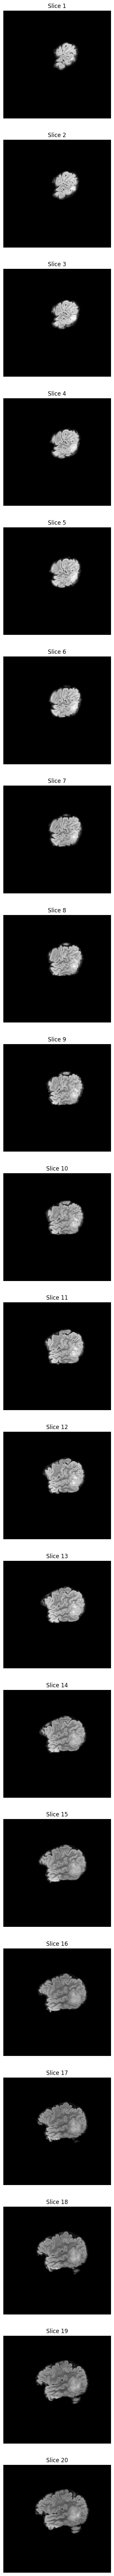

Metadata: Dataset.file_meta -------------------------------
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.15104561700374424891081947119487744795
(0008, 0050) Accession Number                    SH: '00008'
(0008, 0060) Modality                            CS: 'MR'
(0008, 103e) Series Description                  LO: 'T1w'
(0010, 0010) Patient's Name                      PN: '00008'
(0010, 0020) Patient ID                          LO: '00008'
(0018, 0023) MR Acquisition Type                 CS: '2D'
(0018, 0050) Slice Thickness                     DS: '5.0'
(0018, 0081) Echo Time                           DS: None
(001

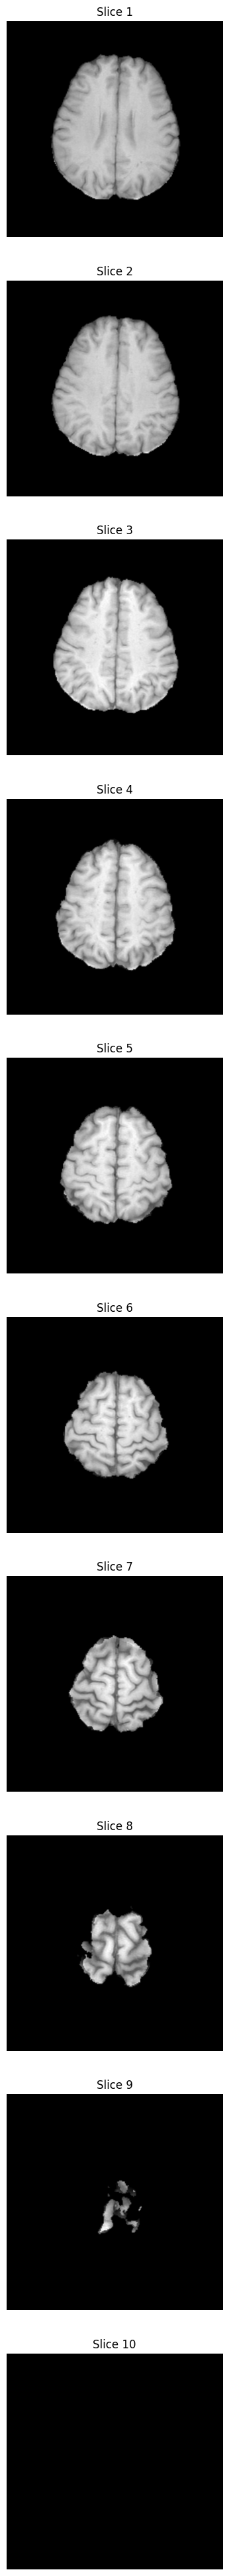

Metadata: Dataset.file_meta -------------------------------
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.45708735358734476530111465404033553004
(0008, 0050) Accession Number                    SH: '00008'
(0008, 0060) Modality                            CS: 'MR'
(0008, 103e) Series Description                  LO: 'T1wCE'
(0010, 0010) Patient's Name                      PN: '00008'
(0010, 0020) Patient ID                          LO: '00008'
(0018, 0023) MR Acquisition Type                 CS: '3D'
(0018, 0050) Slice Thickness                     DS: '1.0'
(0018, 0081) Echo Time                           DS: None
(0

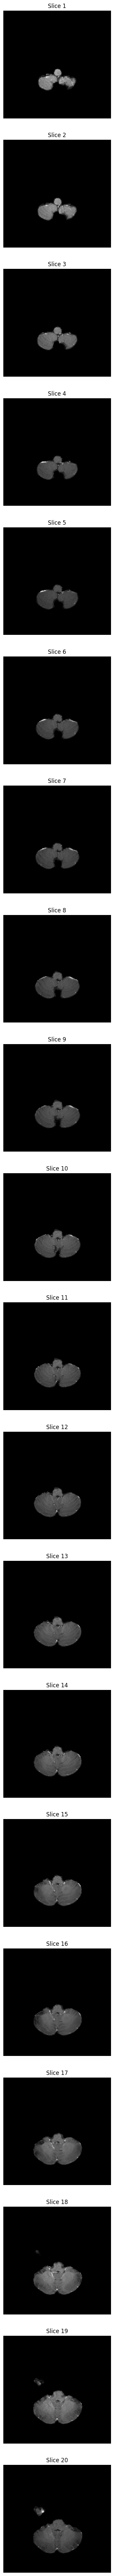

Metadata: Dataset.file_meta -------------------------------
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.12193654134096043648794170199756105706
(0008, 0050) Accession Number                    SH: '00008'
(0008, 0060) Modality                            CS: 'MR'
(0008, 103e) Series Description                  LO: 'T2w'
(0010, 0010) Patient's Name                      PN: '00008'
(0010, 0020) Patient ID                          LO: '00008'
(0018, 0023) MR Acquisition Type                 CS: '3D'
(0018, 0050) Slice Thickness                     DS: '1.0'
(0018, 0081) Echo Time                           DS: None
(001

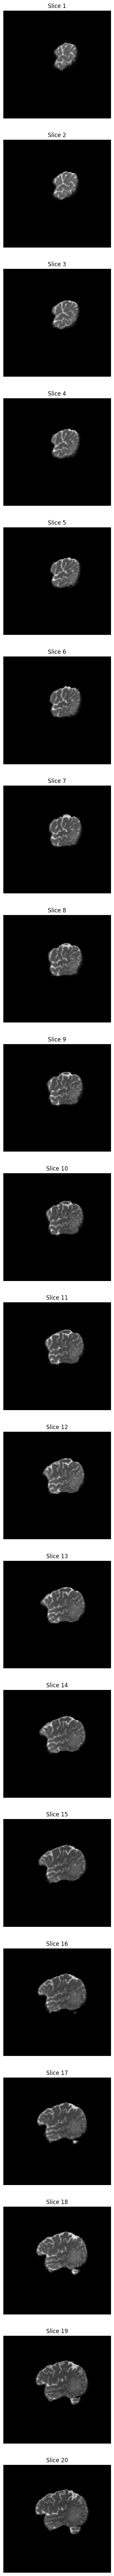

In [23]:
!pip install pydicom

from google.colab import drive
import os
import pydicom
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

def load_mri_slices(directory):
    slices = [pydicom.dcmread(os.path.join(directory, f)) for f in os.listdir(directory) if f.endswith('.dcm')]
    slices.sort(key=lambda x: int(x.InstanceNumber))
    return slices

def print_and_save_metadata(dicom_slice, output_dir):
    print('Metadata:', dicom_slice)
    metadata_output_path = os.path.join(output_dir, 'metadata.txt')
    with open(metadata_output_path, 'w') as file:
        file.write(str(dicom_slice))


def visualize_and_save_slices(slices, output_dir):
    num_slices = len(slices)
    fig, axes = plt.subplots(num_slices, 1, figsize=(10, 5 * num_slices))  # Adjusted for larger images and vertical layout
    for i, slice in enumerate(slices):
        if num_slices == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(slice.pixel_array, cmap='gray')
        ax.set_title(f"Slice {i + 1}")  # Set title to include slice number
        ax.axis('off')
    visualization_output_path = os.path.join(output_dir, 'visualization.png')
    plt.savefig(visualization_output_path)
    plt.show()


def main():
    sequences = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
    base_input_dir = '/content/drive/My Drive/a3-digital-image-processing-tmehtiyev2019/input_pictures/MRI/00008/'
    base_output_dir = '/content/drive/My Drive/a3-digital-image-processing-tmehtiyev2019/output_pictures/MRI/'

    for seq in sequences:
        input_dir = os.path.join(base_input_dir, seq)
        output_dir = os.path.join(base_output_dir, seq)
        os.makedirs(output_dir, exist_ok=True)

        mri_slices = load_mri_slices(input_dir)

        print_and_save_metadata(mri_slices[0], output_dir)
        visualize_and_save_slices(mri_slices[20:40], output_dir)

if __name__ == '__main__':
    main()
